# Plotting Over a Region

Welcome to the **Plotting Over a Region** notebook! In this tutorial, we will cover the steps involved in visualising data on a specific region of the Earth’s surface.

In this notebook, you will learn how to:

- **Download an example .nc file**: We will use historical global temperature data from the CMIP6 collection.
- **Crop data for a region**: Learn how to subset the data to focus on a specific geographical area.
- **Crop a region of the Earth**: Understand how to adjust the Earth’s visualisation to focus on a particular region.
- **Add data above the Earth**: Overlay the cropped data onto the Earth’s surface.

When working with specific regions, it's a good idea to use a higher resolution for better visual detail when cropping.

If you're running this notebook on Gadi or NCI, you should include **gdata/fs38** in your storage setup. If you're not on Gadi, the code will download the ~0.5GB .nc file to your local environment.

In [1]:
import os
import xarray as xr
import accessvis
import numpy as np
import matplotlib.pyplot as plt
accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('Ultra-hig…

## Downloading Data

If you're not running this notebook on Gadi, the following code will download a historical surface temperature .nc file from the NCI THREDDS server and load it into an xarray object. The file is approximately **0.5GB** in size.

This dataset contains global temperature data from the CMIP6 collection, which provides historical climate projections from various models. If you're working on Gadi, ensure that you have access to **gdata/fs38** in your storage.

In [2]:
thredds_server = "https://thredds.nci.org.au/thredds/fileServer/fs38/publications/"
gadi_server = '/g/data/fs38/publications/'

#Temp at the surface
ver = "CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/"
fpath = "r10i1p1f1/day/tas/gn/latest/tas_day_ACCESS-ESM1-5_historical_r10i1p1f1_gn_20000101-20141231.nc"
var = 'tas'
url = f"{thredds_server}{ver}{fpath}"
gadi_path = f"{gadi_server}{ver}{fpath}"


if os.path.exists(gadi_path):
    data_file = gadi_path
else:
    print('Could not load from gadi.')
    data_file = os.path.abspath(os.path.split(url)[-1])

    if not os.path.exists(data_file):
        print(f'Downloading from {url}')
        print(f'Saving to {data_file}')
        accessvis.download(url, filename=data_file)

print(f'{data_file=}')

data_file='/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/day/tas/gn/latest/tas_day_ACCESS-ESM1-5_historical_r10i1p1f1_gn_20000101-20141231.nc'


## Reading the .nc file
Loading the .nc file in xarray->numpy, and taking the last datastep.

In [3]:
ds = xr.open_dataset(data_file)

## Cropping Data to a Region

In this step, we'll focus on plotting the temperature for South-eastern Australia. First, we'll crop the data to the relevant region and apply a suitable colour scheme. The Earth's surface will be cropped later to match the data region.

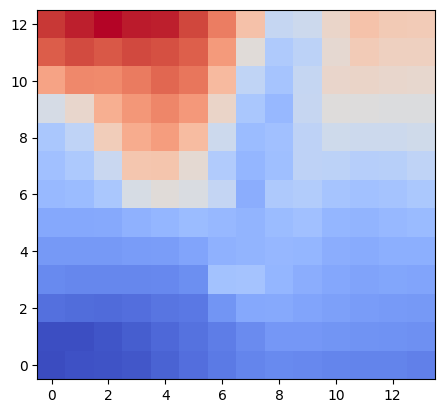

In [12]:
colourmap='coolwarm'

min_lat = -45
max_lat = -29
min_lon = 135
max_lon = 160

cropped_ds = ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

tas = np.array(cropped_ds[var][0])-273.15 # Taking first Converting to celcius
rgba = accessvis.array_to_rgba(tas, colourmap=colourmap)
plt.imshow(rgba, origin='lower') 

## Cropping Earth to a Region
Pass the corner coords to plot_region() to get regional topography view.

New working directory: /media/data/accessvis/gebco
File gebco_equirectangular_21600_x_10800.npz is complete. Skip download.
Returned to:  /home/okaluza/ACCESS-NRI/ACCESS-Visualisation-Recipes



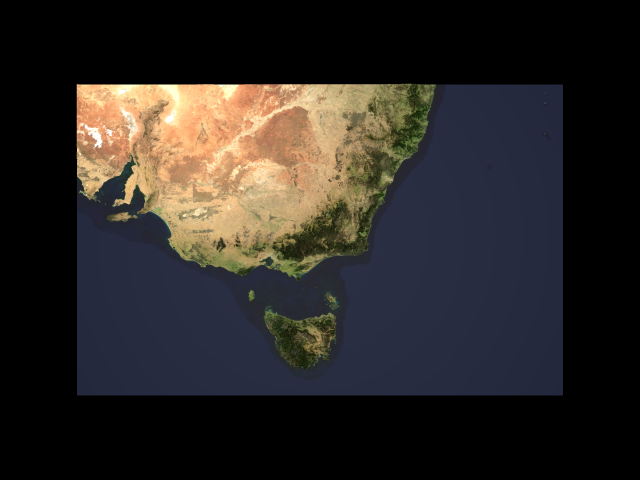

In [13]:
vertical_exaggeration=20
lv = accessvis.plot_region(top_left=(min_lon, min_lat),
                           bottom_right=(max_lon, max_lat),
                           vertical_exaggeration=vertical_exaggeration)
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])
lv.display((640,480))

## Interpolating the Data

To begin, we create a copy of the vertices from the existing surface using the `vertices_copy()` function. This ensures we have a separate copy of the data to modify, as `vertices()` would return a reference to the original data, which we want to avoid altering directly.

Next, we position the new surface above the Earth by adding a 5m offset along the Z=2 direction, ensuring the data is displayed above the Earth's surface.

In [14]:
topo = lv.objects['surface']
V = topo.data.vertices_copy[0]

offset = 5 * accessvis.MtoLL * vertical_exaggeration # this converts 5m to lat/lon units, including vertical exaggeration
V[::,::,2] = V[::,::,2] + offset

Here we are making the surface, and adding temperature data and scale. Note that we set alpha here to allow us to see the earth below.


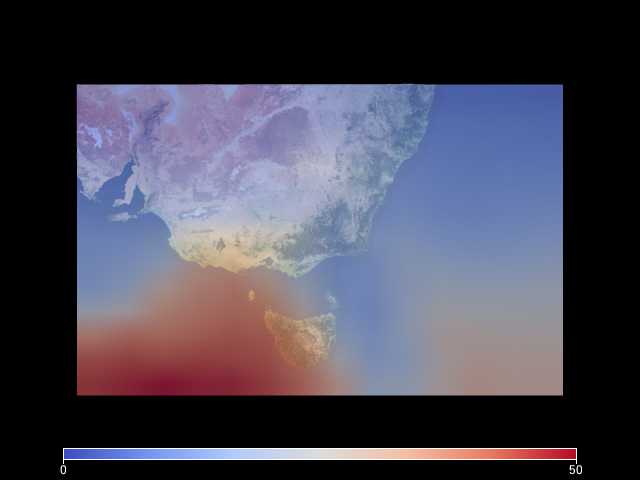

In [15]:
tsurf = lv.triangles('temperature', vertices=V, cullface=True, texture="blank.png", lit=False, alpha=0.6)
tsurf.texture(rgba, flip=True)

cmap = lv.colourmap(colourmap, range=(0,50))
cb = lv.colourbar()

lv.display((640,480))

Note that we can also still rotate and translate the image. This is useful for removing the black border.


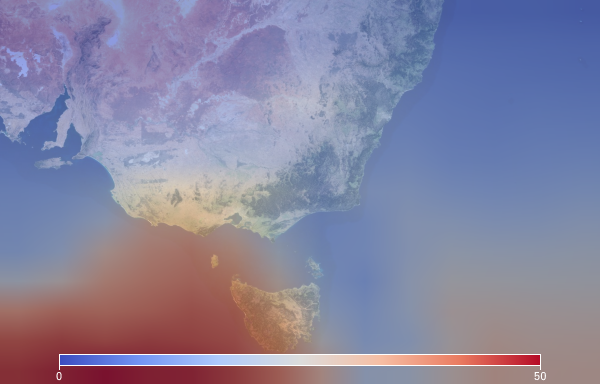

In [16]:
ratio = max_lat-max_lon
x_pix = 600
y_pix = x_pix * (max_lat-min_lat) // (max_lon-min_lon) # This makes the y dimension the same ratio as lat/lon.

lv.rotation(0, 0, 0) # This centres the region
lv.translation(0,0,-19) # this zooms in/out. Adjust to fit your region.

lv.display((x_pix, y_pix))

## Interactive Viewer
The earth is still being plotted in 3d. The interactive viewer demonstrates this.

In [17]:
lv.window()

## Conclusion

In this notebook, we've demonstrated how to:

- Download and crop global temperature data to focus on a specific region, such as South-eastern Australia.
- Apply a colour scheme to visualise the data effectively.
- Interpolate the data to place it above the Earth's surface with a slight offset for better visibility.

By following these steps, you can plot high-resolution data for any region of interest, customise the visualisation with colour schemes, and position the data above the Earth's surface for clearer representation.

Feel free to explore other datasets and apply similar techniques to plot data for different regions or variables, using the tools available in the `accessvis` package!